## 01. Setup & Imports

In [2]:
import numpy as np
import pandas as pd
import os
import random
from datetime import datetime, timedelta
import logging
import json

## 02. Central Configuration

In [3]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)

# Seed
random.seed(42)
np.random.seed(42)

# Riferimento temporale centrale
TODAY = datetime.utcnow()

# Config globale
CONFIG = {
    "n_rows": 5000,
    "asset_type": "property",
    "output_path": "../data/property_dataset_v2.csv",
    "price_per_sqm_range": (1200, 3500),  # ITALY
    "garden_bonus": 10000,
    "balcony_bonus": 5000,
    "garage_bonus": 7000,
    "min_floors_for_elevator": 4,
}

## 03. Base Data

In [4]:
# Static vocabularies
LOCATIONS = [
    "Milan", "Rome", "Naples", "Florence", "Turin",
    "Bologna", "Palermo", "Genoa", "Verona", "Padua",
    "Bari", "Catania", "Venice", "Trieste", "Cagliari",
]

URBAN_TYPE_BY_CITY = {
    "Milan": "urban", "Rome": "urban", "Naples": "urban", "Florence": "urban",
    "Turin": "urban", "Bologna": "urban", "Genoa": "urban",
    "Palermo": "semiurban", "Bari": "semiurban", "Verona": "semiurban",
    "Padua": "semiurban", "Catania": "semiurban", "Trieste": "semiurban",
    "Cagliari": "rural", "Venice": "rural",
}

REGION_BY_CITY = {
    "Milan": "north", "Turin": "north", "Bologna": "north", "Genoa": "north", "Padua": "north", "Verona": "north",
    "Rome": "center", "Florence": "center",
    "Naples": "south", "Bari": "south", "Palermo": "south", "Catania": "south",
    "Trieste": "northeast", "Venice": "northeast", "Cagliari": "islands",
}

ENERGY_CLASSES = ["A", "B", "C", "D", "E", "F", "G"]

## 04. Support Functions

In [5]:
def simulate_condition_score(humidity: float, temperature: float, energy_class: str) -> float:
    """
    Produce un punteggio sintetico di 'condition_score' in [0,1].
    Penalizza umidità alta, temperatura estrema, e classi energetiche basse.
    """
    score = 0.85

    # Penalità umidità
    if humidity > 65:
        score -= 0.15
    elif humidity > 55:
        score -= 0.05

    # Penalità temperatura estrema
    if temperature < 14 or temperature > 24:
        score -= 0.07

    # Correzione per classe energetica
    class_adjust = {
        "A": +0.03, "B": +0.02, "C": 0.00,
        "D": -0.02, "E": -0.04, "F": -0.06, "G": -0.10,
    }
    score += class_adjust.get(energy_class, 0.0)

    # Rumore stocastico
    score += np.random.normal(0, 0.02)

    return round(min(1.0, max(0.0, score)), 3)


def random_recent_timestamp(days_back: int = 60) -> str:
    """
    Genera un timestamp ISO UTC (Z) negli ultimi `days_back` giorni.
    """
    delta_days = random.randint(0, days_back)
    dt = TODAY - timedelta(
        days=delta_days, hours=random.randint(0, 23), minutes=random.randint(0, 59)
    )
    return dt.isoformat(timespec="seconds") + "Z"

## 05. Generate Data Rows

In [6]:
def generate_property(index: int) -> dict:
    size_m2 = np.random.randint(40, 200)
    rooms = np.random.randint(2, 7)
    bathrooms = np.random.randint(1, 4)
    year_built = np.random.randint(1950, 2023)

    floor = np.random.randint(0, 5)
    building_floors = np.random.randint(floor + 1, 10)

    has_elevator = int(building_floors >= CONFIG["min_floors_for_elevator"])
    has_garden = int(random.random() < 0.30)
    has_balcony = int(random.random() < 0.60)
    garage = int(random.random() < 0.50)
    owner_occupied = int(random.random() < 0.65)
    public_transport_nearby = int(random.random() < 0.70)

    energy_class = random.choice(ENERGY_CLASSES)
    humidity = round(np.random.uniform(30, 70), 1)
    temperature = round(np.random.uniform(12, 25), 1)
    noise_level = int(np.random.randint(20, 80))
    air_quality_index = int(np.random.randint(30, 150))

    luxury_score = round(
        0.2 * has_garden +
        0.2 * has_balcony +
        0.2 * garage +
        0.2 * (energy_class in ["A", "B"]) +
        0.2 * (size_m2 > 120),
        2
    )

    env_score = round(
        0.4 * (air_quality_index < 80) +
        0.3 * (humidity >= 35 and humidity <= 60) +
        0.3 * (noise_level < 50),
        2
    )

    location = random.choice(LOCATIONS)
    urban_type = URBAN_TYPE_BY_CITY.get(location, "unknown")
    region = REGION_BY_CITY.get(location, "unknown")

    distance_to_center_km = round(np.random.exponential(scale=3.5), 2)  # media ≈ 3.5 km

    current_year = datetime.utcnow().year
    age_years = current_year - year_built

    base_price_eur = size_m2 * np.random.uniform(*CONFIG["price_per_sqm_range"])
    if energy_class in ["A", "B"]:
        base_price_eur *= 1.05
    if has_garden:
        base_price_eur += CONFIG["garden_bonus"]
    if has_balcony:
        base_price_eur += CONFIG["balcony_bonus"]
    if garage:
        base_price_eur += CONFIG["garage_bonus"]

    valuation_k = round(base_price_eur / 1000, 2)
    price_per_sqm = round((base_price_eur / size_m2), 2)
    condition_score = simulate_condition_score(humidity, temperature, energy_class)
    risk_score = round(min(1.0, max(0.0, (1 - condition_score) + np.random.normal(0, 0.02))), 3)

    return {
        "asset_id": f"asset_{index:04}",
        "asset_type": CONFIG["asset_type"],
        "location": location,
        "region": region,
        "urban_type": urban_type,
        "size_m2": size_m2,
        "rooms": rooms,
        "bathrooms": bathrooms,
        "year_built": year_built,
        "age_years": age_years,
        "floor": floor,
        "building_floors": building_floors,
        "has_elevator": has_elevator,
        "has_garden": has_garden,
        "has_balcony": has_balcony,
        "garage": garage,
        "owner_occupied": owner_occupied,
        "public_transport_nearby": public_transport_nearby,
        "distance_to_center_km": distance_to_center_km,
        "energy_class": energy_class,
        "price_per_sqm": price_per_sqm,
        "humidity_level": humidity,
        "temperature_avg": temperature,
        "noise_level": noise_level,
        "air_quality_index": air_quality_index,
        "luxury_score": luxury_score,
        "env_score": env_score,
        "valuation_k": valuation_k,
        "condition_score": condition_score,
        "risk_score": risk_score,
        "last_verified_ts": random_recent_timestamp(),
    }

## 06. Factory multi-RWA

In [7]:
def generate_asset(asset_type: str, index: int) -> dict:
    """
    Factory di asset per supporto futuro multi-RWA.
    """
    if asset_type == "property":
        return generate_property(index)
    # Future expansion:
    # elif asset_type == "art":
    #     return generate_art(index)
    # elif asset_type == "energy":
    #     return generate_energy_asset(index)
    else:
        raise ValueError(f"[ASSET_FACTORY] Unsupported asset_type: {asset_type}")

## 07. Data Validation

In [8]:
def validate_property(prop_data: dict) -> dict:
    """
    Validazione avanzata di un asset property con correzione automatica.
    Logga le anomalie e corregge valori fuori range o incoerenti.
    """
    validation_errors = []

    # Floor non può superare il numero totale di piani
    if prop_data["floor"] > prop_data["building_floors"]:
        validation_errors.append("floor > building_floors")
        prop_data["floor"] = prop_data["building_floors"]

    # Score tra 0.0 e 1.0
    for field, min_val, max_val in [
        ("condition_score", 0.0, 1.0),
        ("risk_score", 0.0, 1.0),
        ("luxury_score", 0.0, 1.0),
        ("env_score", 0.0, 1.0),
    ]:
        if not (min_val <= prop_data[field] <= max_val):
            validation_errors.append(f"{field} out of range")
            prop_data[field] = float(np.clip(prop_data[field], min_val, max_val))

    # Metri quadri minimi
    if prop_data["size_m2"] < 20:
        validation_errors.append("size_m2 too small")
        prop_data["size_m2"] = 20

    # Valutazione minima (se assente o troppo bassa)
    if prop_data["valuation_k"] < 10:
        validation_errors.append("valuation_k too low")
        prop_data["valuation_k"] = round((prop_data["size_m2"] * 500) / 1000, 2)

    if validation_errors:
        logging.warning(f"[VALIDATION] Asset {prop_data.get('asset_id', 'unknown')} fixed: {validation_errors}")

    return prop_data

## 08. Generate DataFrame

In [9]:
from tqdm import tqdm

REQUIRED_FIELDS = [
    "asset_id", "asset_type", "location", "region", "urban_type",
    "size_m2", "rooms", "bathrooms", "year_built", "age_years",
    "floor", "building_floors", "has_elevator", "has_garden",
    "has_balcony", "garage", "owner_occupied", "public_transport_nearby",
    "distance_to_center_km", "energy_class", "humidity_level",
    "temperature_avg", "noise_level", "air_quality_index",
    "valuation_k", "condition_score", "risk_score",
    "luxury_score", "env_score", "last_verified_ts", "price_per_sqm"
]

def validate_schema(df: pd.DataFrame):
    missing = set(REQUIRED_FIELDS) - set(df.columns)
    assert not missing, f"[SCHEMA ERROR] Missing fields: {missing}"
    logging.info(f"[SCHEMA] ✅ All {len(REQUIRED_FIELDS)} required fields present.")

def generate_dataset_df(config: dict, batch_size: int = 1000, show_progress: bool = True) -> pd.DataFrame:
    logging.info(f"[DATASET] Generating {config['n_rows']} assets of type '{config['asset_type']}' in batches...")

    dfs = []
    n_batches = (config['n_rows'] + batch_size - 1) // batch_size
    iterator = range(n_batches)
    if show_progress:
        iterator = tqdm(iterator, desc="🔄 Generating Batches")

    for batch in iterator:
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, config['n_rows'])

        batch_data = []
        for i in range(start_idx, end_idx):
            try:
                asset = generate_asset(config["asset_type"], i)
                validated = validate_property(asset)  # ✅ qui è corretto
                batch_data.append(validated)
            except Exception as e:
                logging.error(f"[ERROR] Failed to generate asset {i}: {e}")
                continue

        dfs.append(pd.DataFrame(batch_data))

    df = pd.concat(dfs, ignore_index=True)

    validate_schema(df)
    df = df[REQUIRED_FIELDS]

    return df


def generate_quality_report(df: pd.DataFrame) -> dict:
    """Genera un report di qualità e distribuzioni statistiche del dataset."""
    report = {
        'basic_stats': {
            'n_rows': len(df),
            'n_columns': len(df.columns),
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
        },
        'missing_values': df.isnull().sum().to_dict(),
        'duplicates': {
            'duplicate_rows': df.duplicated().sum(),
            'duplicate_asset_ids': df['asset_id'].duplicated().sum()
        },
        'distributions': {}
    }

    for col in df.select_dtypes(include=[np.number]).columns:
        report['distributions'][col] = {
            'mean': df[col].mean(),
            'std': df[col].std(),
            'skewness': df[col].skew(),
            'kurtosis': df[col].kurt(),
            'outliers_pct': (
                ((df[col] < df[col].quantile(0.01)) |
                 (df[col] > df[col].quantile(0.99))).sum() / len(df) * 100
            )
        }

    critical_correlations = []
    corr_matrix = df.select_dtypes(include=[np.number]).corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                critical_correlations.append({
                    'var1': corr_matrix.columns[i],
                    'var2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })

    report['critical_correlations'] = critical_correlations
    return report

In [10]:
# Genera dataset e valida
df = generate_dataset_df(CONFIG, batch_size=1000, show_progress=True)
df = df[REQUIRED_FIELDS]

report = generate_quality_report(df)

# — Assicurati che la cartella logs esista —
import os, json
os.makedirs("../logs", exist_ok=True)

# — Salva il report —
with open("../logs/quality_report.json", "w", encoding="utf-8") as f:
    json.dump(
        report,
        f,
        indent=2,
        default=lambda o: o.item() if hasattr(o, "item") else str(o)
    )

from pprint import pprint
pprint(report['basic_stats'])
pprint(report['duplicates'])

report
df.head()

2025-07-30 00:27:57,679 [INFO] [DATASET] Generating 5000 assets of type 'property' in batches...
🔄 Generating Batches: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.32it/s]
2025-07-30 00:27:58,834 [INFO] [SCHEMA] ✅ All 31 required fields present.


{'memory_usage_mb': np.float64(3.092015266418457),
 'n_columns': 31,
 'n_rows': 5000}
{'duplicate_asset_ids': np.int64(0), 'duplicate_rows': np.int64(0)}


,asset_id,asset_type,location,region,urban_type,size_m2,rooms,bathrooms,year_built,age_years,...,temperature_avg,noise_level,air_quality_index,valuation_k,condition_score,risk_score,luxury_score,env_score,last_verified_ts,price_per_sqm
0,asset_0000,property,Catania,south,semiurban,142,5,1,1964,61,...,17.8,42,104,291.39,0.798,0.183,0.6,0.6,2025-06-02T05:22:57Z,2052.04
1,asset_0001,property,Florence,center,urban,92,3,2,1987,38,...,20.0,77,51,127.28,0.611,0.401,0.4,0.4,2025-06-14T01:43:57Z,1383.48
2,asset_0002,property,Naples,south,urban,54,4,3,2013,12,...,20.8,28,68,186.82,0.659,0.363,0.2,0.7,2025-06-15T09:06:57Z,3459.66
3,asset_0003,property,Trieste,northeast,semiurban,129,6,2,2009,16,...,14.3,36,65,393.92,0.772,0.221,0.6,0.7,2025-07-07T03:11:57Z,3053.61
4,asset_0004,property,Turin,north,urban,43,6,3,1967,58,...,23.6,33,124,60.35,0.640,0.328,0.0,0.3,2025-06-06T01:48:57Z,1403.53


In [11]:
def add_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """Aggiunge features derivate avanzate per machine learning."""
    
    # Indicatori temporali
    df['quarter_built'] = pd.to_datetime(df['year_built'], format='%Y').dt.quarter
    df['decade_built'] = (df['year_built'] // 10) * 10

    # Metriche spaziali
    df['rooms_per_sqm'] = df['rooms'] / df['size_m2']
    df['bathrooms_per_room'] = df['bathrooms'] / df['rooms']
    df['avg_room_size'] = df['size_m2'] / df['rooms']

    # Score compositi
    df['location_premium'] = df['urban_type'].map({
        'urban': 1.2, 'semiurban': 1.0, 'rural': 0.8
    })

    # Indicatori di lusso
    df['amenity_count'] = (
        df['has_garden'] + df['has_balcony'] + 
        df['garage'] + df['has_elevator']
    )

    # Prezzo normalizzato per regione
    region_avg = df.groupby('region')['valuation_k'].transform('mean')
    df['price_vs_region_avg'] = df['valuation_k'] / region_avg

    return df

df = add_advanced_features(df)
df = df[[col for col in REQUIRED_FIELDS if col in df.columns] + 
        [col for col in df.columns if col not in REQUIRED_FIELDS]]

## 09. Export CSV

In [12]:
def export_dataset(df: pd.DataFrame, config: dict):
    """Esporta il dataset in più formati: CSV, Parquet, JSON, Metadata."""
    base_path = os.path.splitext(config['output_path'])[0]
    
    os.makedirs(os.path.dirname(config["output_path"]), exist_ok=True)
    
    df.to_csv(config["output_path"], index=False)
    logging.info(f"[EXPORT] ✅ CSV salvato in {config['output_path']}")

    parquet_path = f"{base_path}.parquet"
    df.to_parquet(parquet_path, engine="pyarrow", compression="snappy")
    logging.info(f"[EXPORT] ✅ Parquet salvato in {parquet_path}")

    json_sample_path = f"{base_path}_sample.json"
    df.head(100).to_json(json_sample_path, orient="records", indent=2)
    logging.info(f"[EXPORT] ✅ JSON sample salvato in {json_sample_path}")

    # 4. Metadata
    metadata = {
        "generated_at": datetime.utcnow().isoformat(),
        "n_rows": int(len(df)),
        "n_features": int(df.shape[1]),
        "config": config,
        "schema": df.dtypes.astype(str).to_dict(),
    }

    metadata_path = f"{base_path}_metadata.json"
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2, default=lambda o: o.item() if hasattr(o, "item") else str(o))
    logging.info(f"[EXPORT] ✅ Metadata salvati in {metadata_path}")

In [13]:
export_dataset(df, CONFIG)

df.describe(include="all").T.head(5)

2025-07-30 00:27:59,875 [INFO] [EXPORT] ✅ CSV salvato in ../data/property_dataset_v2.csv
2025-07-30 00:28:00,793 [INFO] [EXPORT] ✅ Parquet salvato in ../data/property_dataset_v2.parquet
2025-07-30 00:28:00,818 [INFO] [EXPORT] ✅ JSON sample salvato in ../data/property_dataset_v2_sample.json
2025-07-30 00:28:00,824 [INFO] [EXPORT] ✅ Metadata salvati in ../data/property_dataset_v2_metadata.json


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
asset_id,5000,5000,asset_0000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asset_type,5000,1,property,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5000,15,Bari,382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,5000,5,north,1917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
urban_type,5000,3,urban,2326,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(5000, 39)
['asset_id', 'asset_type', 'location', 'region', 'urban_type', 'size_m2', 'rooms', 'bathrooms', 'year_built', 'age_years', 'floor', 'building_floors', 'has_elevator', 'has_garden', 'has_balcony', 'garage', 'owner_occupied', 'public_transport_nearby', 'distance_to_center_km', 'energy_class', 'humidity_level', 'temperature_avg', 'noise_level', 'air_quality_index', 'valuation_k', 'condition_score', 'risk_score', 'luxury_score', 'env_score', 'last_verified_ts', 'price_per_sqm', 'quarter_built', 'decade_built', 'rooms_per_sqm', 'bathrooms_per_room', 'avg_room_size', 'location_premium', 'amenity_count', 'price_vs_region_avg']
           size_m2        rooms    bathrooms   year_built    age_years  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    119.623000     3.982600     2.001600  1985.787200    39.212800   
std      46.093381     1.419401     0.818371    21.190463    21.190463   
min      40.000000     2.000000     1.000000  1950.000000     3.0

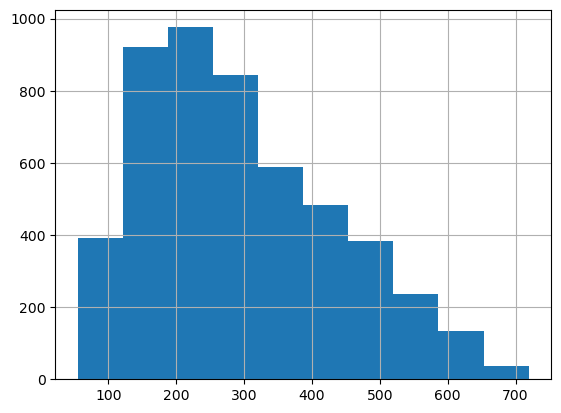

In [14]:
print(df.shape)
print(df.columns.tolist())
print(df.describe())
print(df['location'].value_counts())
print(df['valuation_k'].hist())